# Basic Operations - Example

The code below shows some basic operations that can be done to images. 

1. Addition
2. Subtraction
3. Multiplication
4. Logarithmzation
5. Exponentialization
6. [Otsu Thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method)
7. [Histogram calculation](https://en.wikipedia.org/wiki/Image_histogram)
8. [Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization)
9. Histogram expansion and contraction

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import imageio.v3 as iio

## Functions

In [38]:
def normalize(img : np.ndarray, min = 0.0, max = 1.0):
  """Function that converts an image to the given desired range.

  Parameters
  ----------

  img : np.ndarray
    Image to be normalized.
  min : float
    Bottom value of the new range for conversion.
  max : float
    Top value of the new range for conversion."""
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min

def to_image(img : np.ndarray):
  """Converts an image to the 8-bit unsigned integer range

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""
  
  return normalize(img, 0.0, 255.0).astype(np.uint8)

def convert_to_grayscale(img : np.ndarray):
  """Function that converts an image to grayscale with standard color weights.

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""

  return to_image(0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2])

In [39]:
def avg(img1 : np.ndarray, img2 : np.ndarray):
    assert img1.shape == img2.shape, "The two images should have the same size and color channels."
    return (img1 + img2)/2.0

def gaussian(shape : tuple, sigma : float, x0 : np.ndarray = np.array([0.0, 0.0])):
    x = np.arange(-shape[1], shape[1], 2.0)
    y = np.arange(-shape[0], shape[0], 2.0)
    x, y = np.meshgrid(x, y)
    return np.exp(-((x - x0[0])**2 + (y - x0[1])**2)/(2*sigma**2))

def log(img : np.ndarray):
    n_img = np.zeros_like(img)
    n_img[img > 0] = np.log(img[img > 0])
    return to_image(n_img)

def histogram(img : np.ndarray):
    """Produces a histogram of the image. 
    Returns a tuple with the unique values and its counts.
    
    Parameters
    ----------
     
    img : np.ndarray (N, M)
        Grayscale image to be processed."""
    
    val, counts = np.unique(img, return_counts=True)

    rang = np.arange(0, 256, 1).astype(np.int64)
    hist = np.zeros_like(rang).astype(np.int64)
    hist[val] += counts
    
    return rang, hist


def equalization(img : np.ndarray):
    """Applies a histogram equalization onto the given image.
     
    Parameters
    ----------
     
    img : np.ndarray
        Image to be equalized"""
    
    val, count = histogram(img)

    P = img.shape[0]*img.shape[1]
    
    ps = count/P

    cumsum = lambda p, i : np.sum(p[:i])

    new_img = np.zeros_like(img)

    for i in range(256):
        new_img[img == i] = int(cumsum(ps, i)*255)

    return new_img

def thresholding(img : np.ndarray, threshold : float = 0.5):
  """Limiarizes the image given a threshold. If the image is not on grayscale format,
  it will be converted to and then limiarized.
  
  Parameters
  ----------
  
  img : np.ndarray
    Image to be limiarized.
  threshold : float inside the range (0.0, 1.0]
    Threshold to limiarize the image."""
  assert 0.0 < threshold < 1.0, 'threshold out of range of (0.0, 1.0].'
  new_img = convert_to_grayscale(img) if len(img.shape) > 2 else np.copy(img)

  new_img[img < threshold] = 0.0
  new_img[img >= threshold] = 1.0

  return new_img

def otsu_thresholding(img):
    """Applies an otsu thresholding to an image.
     
    Parameters
    ----------
    
    img : np.ndarray
        Image to be thresholded."""
    val, counts = histogram(img)

    P = img.shape[0]*img.shape[1]

    p = counts/P

    cumsum = lambda p, i, L : np.sum(p[i:L])

    T = np.arange(0, p.shape[0], 1, dtype=int)

    w0 = np.array([cumsum(p, 0, T[i]) for i in range(T.shape[0])])
    w1 = np.array([cumsum(p, T[i], p.shape[0]) for i in range(T.shape[0])])

    mi0 = np.zeros_like(w0)
    mi1 = np.zeros_like(w1)

    mi0[w0 != 0] = np.array([np.sum(i*p[0 : T[i]]) for i in range(T.shape[0])])[w0 != 0]
    mi1[w1 != 0] = np.array([np.sum(i*p[T[i]: p.shape[0]]) for i in range(T.shape[0])])[w1 != 0]

    mi0[w0 != 0] = mi0[w0 != 0]/w0[w0 != 0]
    mi1[w1 != 0] = mi1[w1 != 0]/w1[w1 != 0]

    sigma_b = w0*w1*(mi0 - mi1)**2

    threshold = T[np.where(sigma_b == np.nanmax(sigma_b))[0][0]]/256.0

    return to_image(thresholding(normalize(img), threshold))


def histogram_resize(img : np.ndarray, rate : float):
    """Resizes the histogram by a given rate.
     
    Parameters
    ----------
    img : np.ndarray
        Target image.
    rate : float
        Rate of resizing.
    """

    val = np.arange(0.0, 256.0, 1.0)

    new_max = 255*rate

    diff = new_max - 255

    new_min = 0 - int(diff//2)
    new_max = 255 + int(diff//2)

    new_hist = normalize(val, new_min, new_max).astype(int)

    new_hist[new_hist < 0] = 0
    new_hist[new_hist >= 255] = 255

    new_img = np.copy(img)

    for value in range(256):
        new_img[img == value] = new_hist[value]

    return new_img.astype(np.uint8)

In [40]:
img = iio.imread("imagens/granny.png")
img2 = iio.imread("imagens/granny2.jpeg")

(1600, 1200)
(1600, 1200)


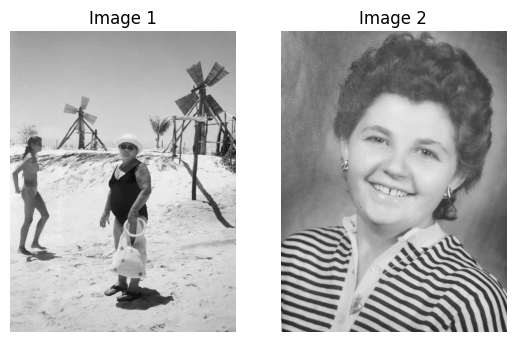

In [41]:
img = convert_to_grayscale(img)
img2 = convert_to_grayscale(img2)

plt.subplot(121)
plt.imshow(img, cmap = "gray")
plt.title("Image 1")
plt.axis("off")

plt.subplot(122)
plt.imshow(img2, cmap = "gray")
plt.title("Image 2")
plt.axis("off")

print(img.shape)
print(img2.shape)

## Basic Operations


In [42]:
img_com = iio.imread("imagens/com.jpeg")
img_sem = iio.imread("imagens/sem.jpeg")

diff_x = (img_com.shape[1] - img.shape[1])//2
diff_y = (img_com.shape[0] - img.shape[0])//2

print(diff_x, diff_y)

img_com = convert_to_grayscale(img_com)
img_sem = convert_to_grayscale(img_sem)

-222 0


(-0.5, 1199.5, 1599.5, -0.5)

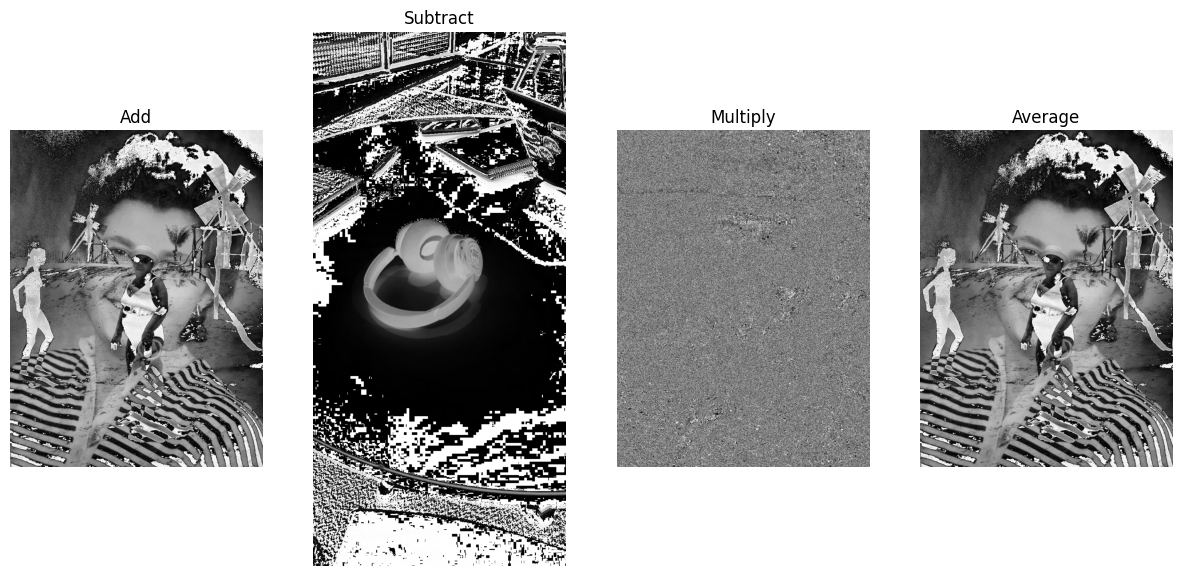

In [43]:
plt.figure(figsize=(15, 15))

plt.subplot(141)
plt.imshow(to_image(img + img2), cmap = "gray")
plt.title("Add")
plt.axis("off")

plt.subplot(142)
plt.imshow(to_image(img_com - img_sem), cmap = "gray")
plt.title("Subtract")
plt.axis("off")

plt.subplot(143)
plt.imshow(to_image(img*img2), cmap = "gray")
plt.title("Multiply")
plt.axis("off")

plt.subplot(144)
plt.imshow(to_image(avg(img, img2)), cmap = "gray")
plt.title("Average")
plt.axis("off")

(-0.5, 1199.5, 1599.5, -0.5)

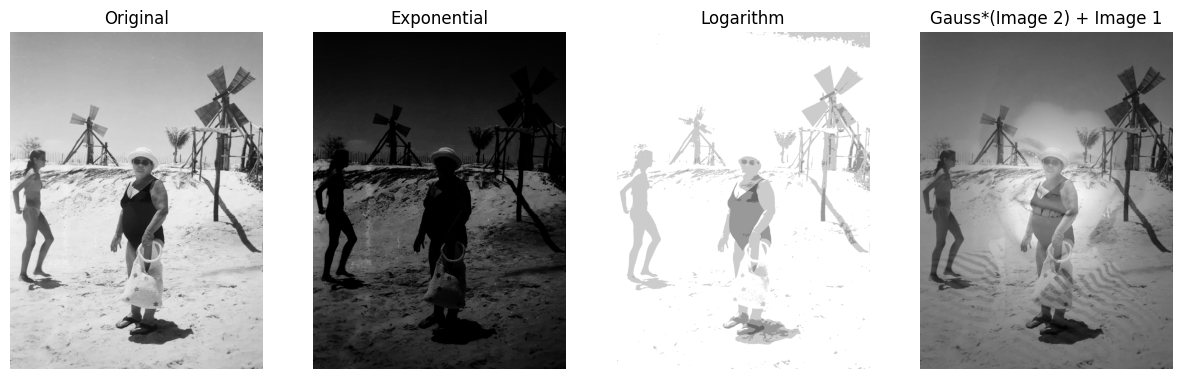

In [44]:
plt.figure(figsize=(15, 15))

plt.subplot(141)
plt.imshow(img, cmap = "gray")
plt.title("Original")
plt.axis("off")

plt.subplot(142)
plt.imshow(np.exp(normalize(img, 0.0, 10.0)), cmap = "gray")
plt.title("Exponential")
plt.axis("off")

plt.subplot(143)
plt.imshow(log(img), cmap = "gray")
plt.title("Logarithm")
plt.axis("off")
plt.subplot(144)
plt.imshow(gaussian(img.shape, 600.0)*img2 + img, cmap = "gray")
plt.title("Gauss*(Image 2) + Image 1")
plt.axis("off")


## Histogram

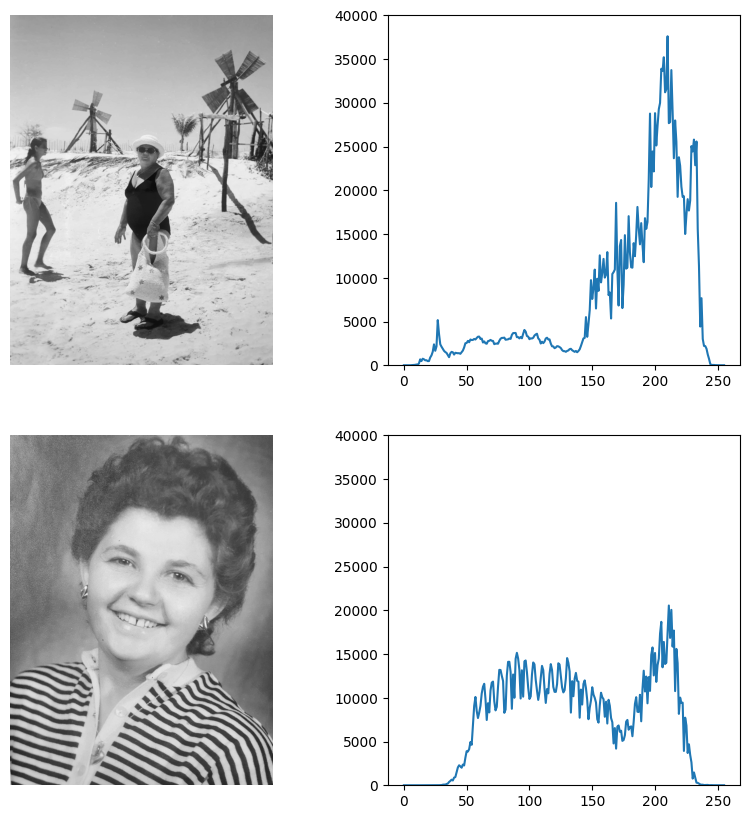

In [45]:
val1, counts1 = histogram(img)
val2, counts2 = histogram(img2)

plt.figure(figsize = (10, 10))

plt.subplot(221)
plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.subplot(222)
plt.ylim(0.0, 40000)
plt.plot(val1, counts1)
plt.subplot(223)
plt.imshow(img2, cmap = "gray")
plt.axis("off")
plt.subplot(224)
plt.ylim(0.0, 40000)
plt.plot(val2, counts2)



## Histogram Equalization

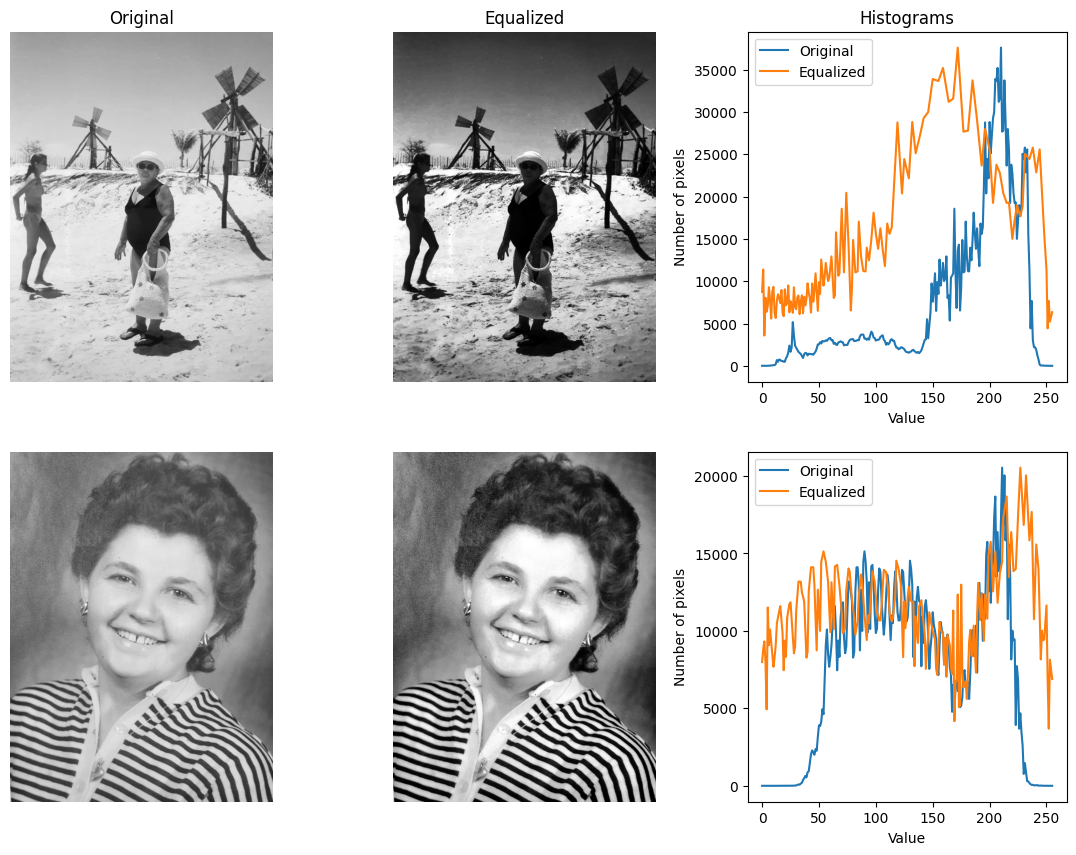

In [46]:
eq1 = to_image(equalization(img))
eq2 = to_image(equalization(img2))

plt.figure(figsize=(14, 10))

plt.subplot(231)
plt.title("Original")
plt.imshow(img, cmap = "gray")
plt.axis("off")

plt.subplot(232)
plt.title("Equalized")
plt.imshow(eq1, cmap = "gray")
plt.axis("off")

val_3, counts_3 = histogram(img)
val_4, counts_4 = histogram(eq1)

val_4 = val_4[counts_4 != 0]
counts_4 = counts_4[counts_4 != 0]

plt.subplot(233)
plt.title("Histograms")
plt.plot(val_3, counts_3, label = "Original")
plt.plot(val_4, counts_4, label = "Equalized")
plt.xlabel("Value")
plt.ylabel("Number of pixels")
plt.legend()

plt.subplot(234)
plt.imshow(img2, cmap = "gray")
plt.axis("off")

plt.subplot(235)
plt.imshow(eq2, cmap = "gray")
plt.axis("off")

val_5, counts_5 = histogram(img2)
val_6, counts_6 = histogram(eq2)

val_6 = val_6[counts_6 != 0]
counts_6 = counts_6[counts_6 != 0]

plt.subplot(236)
plt.plot(val_5, counts_5, label = "Original")
plt.plot(val_6, counts_6, label = "Equalized")
plt.xlabel("Value")
plt.ylabel("Number of pixels")
plt.legend()

## Otsu Thresholding

(-0.5, 1199.5, 1599.5, -0.5)

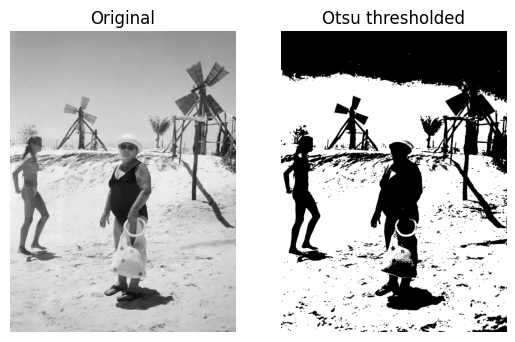

In [47]:
plt.subplot(121)
plt.title("Original")
plt.imshow(img, cmap = "gray")
plt.axis("off")

plt.subplot(122)
plt.title("Otsu thresholded")
plt.imshow(otsu_thresholding(img), cmap = "gray")
plt.axis("off")

## Histogram expansion and contraction

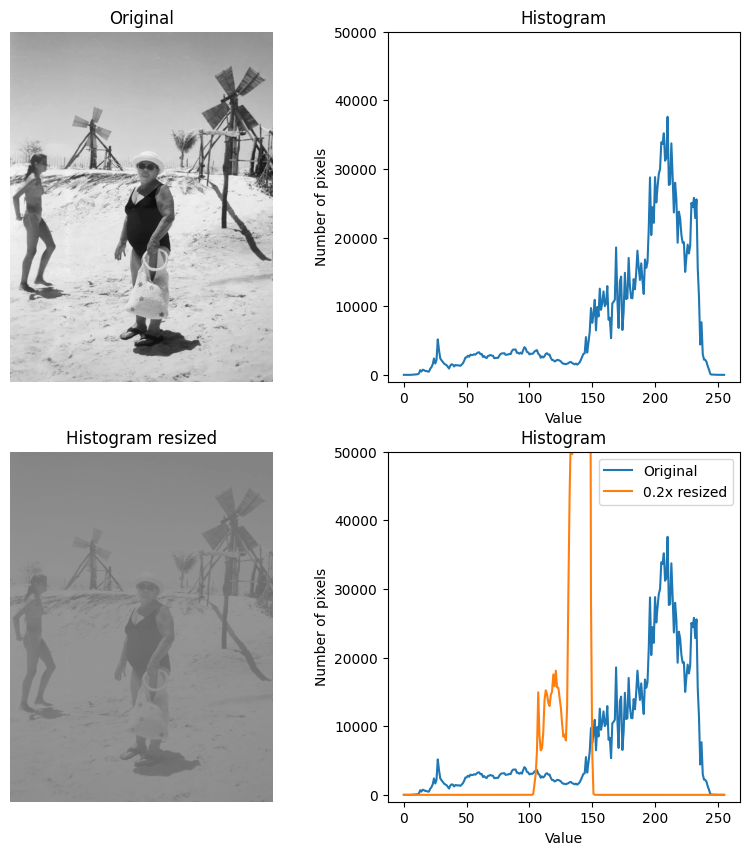

In [49]:
rate = 0.2

resize = histogram_resize(img, rate)

nmin = np.min(resize)/255.0
nmax = np.max(resize)/255.0

# overcoming the imshow issue with vmin and vmax
if rate < 1.0:
    resize[0, 0] = 0
    resize[-1, -1] = 255

val_i, count_i = histogram(img)
val_r, count_r = histogram(resize)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("Original")
plt.imshow(img, cmap = "gray")
plt.axis("off") 

plt.subplot(222)
plt.title("Histogram")
plt.plot(val_i, count_i) 
plt.xlabel("Value")
plt.ylabel("Number of pixels")
plt.ylim(-1000, 50000)

plt.subplot(223)
plt.title("Histogram resized")
plt.imshow(resize, cmap = "gray")
plt.axis("off")

plt.subplot(224)
plt.title("Histogram")
plt.plot(val_i, count_i, label = "Original")
plt.plot(val_r, count_r, label = f'{rate}x resized')
plt.xlabel("Value")
plt.ylabel("Number of pixels")
plt.ylim(-1000, 50000)
plt.legend()
